# COVID19 worldwide case fatality rate analysis 

### Scientific Programming course project

### Tim Hensen, i6217294

# Introduction

COVID19 is a deadly disease, caused by the SARSCoV2 virus and has caused a pandemic in 2020. The mortality rate of the disease has been estimated to be arround 0.2%. This is however a rough estimate as it varies drastically between countries. These variations depend on a many risk factors. This project aims to analyze which risk factors might have the greatest effect on the COVID19 mortality rate. Secondly, this project aims to analyze correlations between risk factors. Finally, the project aims to find clusters of similar countries based on the most important risk factors. Information about the cases and deaths for each country up until september 11 2020 are taken from "Our world in data" (https://ourworldindata.org/). Demographic information and possible risk factors, like the percentage of smokers or the obesity prevalence are also downloaded from this website. This Jupyter notebook consists of three parts: Quality control and preprocessing, Regression analyses, Correlation analyses and Clustering analysis

# Part 1: Quality control and preprocessing

### Importing data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn import preprocessing
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [2]:
# importing main dataset
df = pd.read_csv("owid_main_agi.csv")

# Raw data inspection
df.head()

# We only need to use the total cases and deaths, so:
df_total = df.loc[df['date'] == '2020-09-11']

In [3]:
# Import extra datasets
dfa = pd.read_csv('asthma_agi.csv')
dfp = pd.read_csv('air_pollution_agi.csv')
dfs = pd.read_csv('smoking.csv')
dfo = pd.read_csv('obesity.csv')

# Select only latest year of measurement
df_at = dfa.loc[dfa['Year'] == 2017]
df_pt = dfp.loc[dfp['Year'] == 2016]
df_st = dfs.loc[dfs['Year'] == 2012]
df_ot = dfo.loc[dfo['Year'] == 2016]

In [16]:
# Merge new data with main dataset using left join (all extra datasets have more countries than main dataset)
df_ta = df_total.merge(df_at, on='location', how='left')
df_tp = df_ta.merge(df_pt, on='location', how='left')
df_ts = df_tp.merge(df_st, on='location', how='left')
df_to = df_ts.merge(df_ot, on='location', how='left')

df_to = df_to.drop(['Code_x', 
                    'Code_y', 
                    'Year_x', 
                    'Year_y',
                    ' mean annual exposure (micrograms per cubic meter)'], axis=1)

### Data overview

First, the data is inspected. 209 countries and the world average are displayed in the rows. 20 columns with information about the countries are present. The number of nonzero values for each column varies. This is being handled in the data cleaning phase.

In [19]:
df_to.shape

(211, 21)

In [18]:
df_to.head()

,location,date,total_cases_per_million,total_deaths_per_million,population_density,median_age,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Asthma Prevalence (m/f) Age-standardized,PM2.5 air pollution,Daily smoking prevalence,Prevalence of obesity (both sexes) - WHO (2019)
0,Afghanistan,2020-09-11,990.846,36.477,54.422,18.6,1.337,1803.987,NaN,597.029,...,NaN,NaN,37.746,0.50,64.83,0.498,6.215770,62.854857,11.9,5.5
1,Albania,2020-09-11,3773.716,112.586,104.871,38.0,8.643,11803.431,1.1,304.195,...,7.1,51.2,NaN,2.89,78.57,0.785,2.870007,14.634008,20.5,21.7
2,Algeria,2020-09-11,1082.939,36.282,17.348,29.1,3.857,13913.839,0.5,278.364,...,0.7,30.4,83.741,1.90,76.88,0.754,6.127563,37.230956,11.2,27.4
3,Andorra,2020-09-11,16838.154,685.951,163.755,NaN,NaN,NaN,NaN,109.135,...,29.0,37.8,NaN,NaN,83.73,0.858,6.588128,10.879472,26.6,25.6
4,Angola,2020-09-11,94.078,3.834,23.890,16.8,1.362,5819.495,NaN,276.045,...,NaN,NaN,26.664,NaN,61.15,0.581,5.196785,36.240479,8.7,8.2


In [7]:
df_to.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 210
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   location                                         211 non-null    object 
 1   date                                             211 non-null    object 
 2   total_cases_per_million                          209 non-null    float64
 3   total_deaths_per_million                         210 non-null    float64
 4   population_density                               199 non-null    float64
 5   median_age                                       186 non-null    float64
 6   aged_70_older                                    185 non-null    float64
 7   gdp_per_capita                                   183 non-null    float64
 8   extreme_poverty                                  122 non-null    float64
 9   cardiovasc_death_rate           

## Preprocessing

### Case fatality rate

In order to obtain the most important features, the case fatality rate first has to be calculated for each country. Large variation between countries can indeed be seen in the boxplot below as they vary between 0% in Timor and 28% in Yemen. Note that the Case fatality rate is shown as a fraction and not a perentage of the total deaths/total cases. 

In [ ]:
# Add mortality rate (cfr)
df_new = df_to
case = df_new['total_cases_per_million']
death = df_new['total_deaths_per_million']
df_new['CFR'] = [death / case for (case, death) in zip(case, death)]

                  location       CFR
206                  Yemen  0.289565
96                   Italy  0.125669
197         United Kingdom  0.116179
18                 Belgium  0.108472
124                 Mexico  0.106764
..                     ...       ...
158  Saint Kitts and Nevis  0.000000
159            Saint Lucia  0.000000
188                  Timor  0.000000
170               Slovakia       NaN
210          International       NaN

[211 rows x 2 columns]


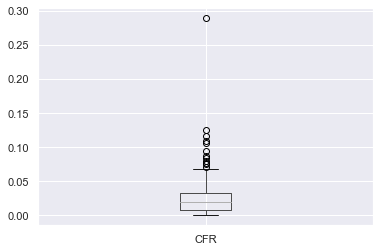

In [9]:
# Explore mortality rates per country
df_new_cfr = df_new.iloc[:,[0,21]]
df_new_cfr = df_new_cfr.sort_values('CFR', axis=0, ascending=False)
print(df_new_cfr)
df_new.boxplot(column = 'CFR')

### Data cleaning: missing values

Here, the location and date are first removed to make sure the dataset only contains numeric data. The percentage of missing values in each feature are investigated and columns with over 30% of missing variables are deleted. The variables: handwashing_facilities, extreme_poverty, male_smokers and female_smokers have a missing value rate of over 30%, meaning that no meaningfull data analysis can be done with these variables and that these features will be deleted. 

In [45]:
# Remove non number (date and location) columns for visualization and further data exploration. 
# The total_cases and deaths per_million are also removed as they are only neede for creating the CFR feature
# df_countries = df_new['location']!!!!!!!!!!!!
df_values = df_new.iloc[:, 4:]

In [46]:
# Are there missing values?
missing = df_values.isnull().sum(axis = 0)
perc_miss = (missing/210) *100
print(perc_miss.sort_values(ascending = False))

handwashing_facilities                             56.666667
extreme_poverty                                    42.380952
male_smokers                                       34.285714
female_smokers                                     33.333333
hospital_beds_per_thousand                         21.904762
Prevalence of obesity (both sexes) - WHO (2019)    16.666667
Daily smoking prevalence                           15.238095
human_development_index                            15.238095
gdp_per_capita                                     13.333333
PM2.5 air pollution                                12.857143
aged_70_older                                      12.380952
Asthma Prevalence (m/f) Age-standardized           11.904762
median_age                                         11.904762
cardiovasc_death_rate                              11.904762
diabetes_prevalence                                 8.571429
population_density                                  5.714286
life_expectancy         

In [70]:
# Remove variables with over 30 percent missing values
df_values1 = df_values.drop(df_values[['extreme_poverty', 
                                       'handwashing_facilities', 
                                       'male_smokers', 
                                       'female_smokers']], axis=1)
missing1 = df_values1.isnull().sum(axis = 0)
perc_miss1 = (missing1/211) *100
print(perc_miss1.sort_values(ascending = False))

hospital_beds_per_thousand                         21.800948
Prevalence of obesity (both sexes) - WHO (2019)    16.587678
Daily smoking prevalence                           15.165877
human_development_index                            15.165877
gdp_per_capita                                     13.270142
PM2.5 air pollution                                12.796209
aged_70_older                                      12.322275
Asthma Prevalence (m/f) Age-standardized           11.848341
cardiovasc_death_rate                              11.848341
median_age                                         11.848341
diabetes_prevalence                                 8.530806
population_density                                  5.687204
life_expectancy                                     1.895735
CFR                                                 0.947867
dtype: float64


If a country has missing values in its features these countries are removed from the datase. Algorithmic imputing techniques like knn doesn't portray reality because their is no connection between the alphabetic order of the countries and the variable values. 

In [71]:
# Removing rows with  any missing values
df_values2 = df_values1.dropna()

### Checking data for strange values

To make sure that their are no strange values that might skew the results, the number of negative values and the minimum/maximum value of each feature is printed. No strange values were found.

In [50]:
# Find for each column the number of negative values
df_values2.to_numpy()
np.sum(np.array(df_values2) < 0, axis=0)  

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
# Are there any strange values for each variable?
# display minimum higher than zero
a = np.array(df_values2.min(axis=0))
b = np.array(df_values2.max(axis=0))
c = df_values2.columns
table = zip(c,a,b)
print(tabulate(table, headers= ['column', 'min', 'max'], tablefmt="presto"))

 column                                          |       min |           max
-------------------------------------------------+-----------+---------------
 population_density                              |   1.98    |   7915.73
 median_age                                      |  15.1     |     48.2
 aged_70_older                                   |   0.526   |     18.493
 gdp_per_capita                                  | 661.24    | 116936
 cardiovasc_death_rate                           |  79.37    |    724.417
 diabetes_prevalence                             |   0.99    |     22.02
 hospital_beds_per_thousand                      |   0.1     |     13.05
 life_expectancy                                 |  53.28    |     84.63
 human_development_index                         |   0.354   |      0.953
 Asthma Prevalence (m/f) Age-standardized        |   2.23679 |     10.7058
 PM2.5 air pollution                             |   5.19528 |    203.744
 Daily smoking prevalence               

## Outlier detection and data visualization

In this subsection, the dataset will be visualially inspected by boxplot and pca plot.

### Log transformation and scaling  

To obtain the best visualization, the data needs to be scaled by mean centering. To decreases skewness of the data, a log transform is performed. Before log transformation, rows with zero values need to be removed. The CFR column has 10 rows with a value of zero. This is the result of some countries having no data or no cases/deaths of COVID19.

In [72]:
#Find rows where the CFR is 0
df_values2_index = df_values2[ df_values2['CFR'] == 0 ].index
df_values2_index

Int64Index([22, 33, 61, 78, 106, 127, 159, 160, 166, 188], dtype='int64')

In [92]:
#Remove rows where the CFR is 0
df_values2a = df_values2.drop(df_values2_index)

# Log transform the values
df_values2b = np.log2(df_values2a)

# Mean center scaling
df_scaled = StandardScaler().fit_transform(df_values2b)

# Make new columns names based on the column position of the column header.
feat_cols = [str(i) for i in range(df_scaled.shape[1])]
df_norm = pd.DataFrame(df_scaled,columns=feat_cols)
df_norm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.261215,-1.617844,-1.513990,-1.565425,2.052282,0.637580,-1.636101,-1.292961,-1.586502,0.825980,1.130653,-0.465388,-1.767434,0.647369
1,0.228687,0.755721,0.815858,-0.003251,0.645456,0.733238,0.359973,0.685041,0.409965,-1.597343,-0.715185,0.579293,0.439277,0.407642
2,-1.115075,-0.130840,-0.191397,0.133551,0.460313,-0.042232,-0.117202,0.461289,0.233206,0.781160,0.467424,-0.581834,0.814249,0.539907
3,0.821187,0.195141,0.036908,0.495111,-0.319953,1.246511,0.671426,0.480010,0.381933,1.432946,-0.627272,-2.871658,0.217169,0.472462
4,-1.167269,0.174377,0.628922,0.389760,-0.325178,-0.429655,0.983667,0.433142,0.627999,0.029039,-0.757945,0.463433,0.866209,0.002454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,-0.564617,-0.142276,-0.172764,0.287588,-0.179473,-0.117861,-1.101354,-0.204969,0.273746,-0.342818,0.028740,0.173968,0.705003,-1.099681
139,1.033621,0.246492,0.060143,-0.542485,0.197901,-0.262630,0.239662,0.261262,-0.130569,-0.481529,0.026560,0.597942,-3.315372,0.525692
140,-0.273864,-1.327274,-1.303149,-1.730537,1.661294,-0.482735,-1.253279,-1.090215,-2.011684,-0.071679,1.312391,-0.112502,0.056262,2.999354
141,-0.904614,-1.782622,-1.335908,-0.970439,0.102548,-1.069965,-0.058843,-1.443256,-0.857698,-0.760051,0.216961,-0.547837,-1.145056,0.096181


In [96]:
# Make sure mean centering worked correcly by plotting the mean. The features should have a mean arround zero. 
df_norm.mean()

0    -3.144338e-16
1    -1.892814e-15
2     2.329139e-16
3    -3.990592e-16
4     1.628068e-15
5    -4.068230e-16
6    -2.057406e-17
7     2.381933e-15
8     1.133514e-16
9    -1.878839e-16
10   -5.843228e-16
11    8.866257e-16
12    4.590345e-16
13   -8.695453e-17
dtype: float64

### Boxplot visualization

The boxplots below show the distribution over all countries for each feature. The center of the notched boxplots show the median value. The boxplots also show that most feature have a few outliers. These are univariate outliers.

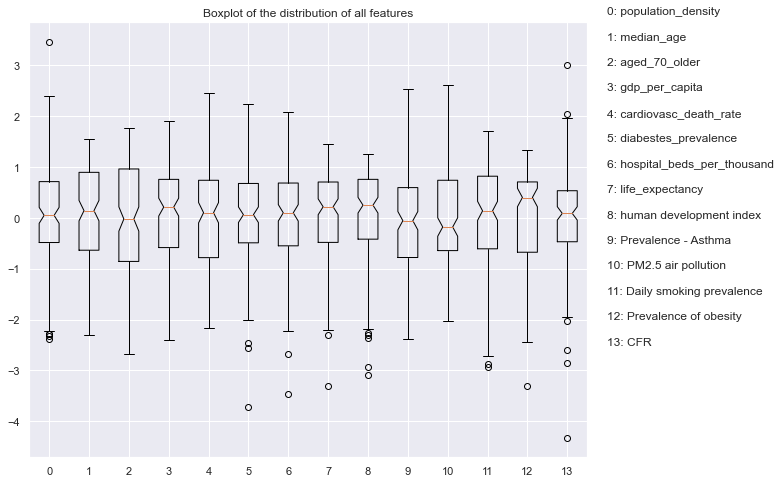

In [89]:
# Transpose dataset to make a boxplot for each feature
df_normT = df_norm.T

# Plot the figure
fig = plt.figure(figsize=(10,8))
plt.title('Boxplot of the distribution of all features')
plt.boxplot(df_normT, notch='True', labels=feat_cols)

plt.text(15, 4, '0: population_density')
plt.text(15, 3.5, '1: median_age')
plt.text(15, 3, '2: aged_70_older')
plt.text(15, 2.5, '3: gdp_per_capita')
plt.text(15, 2, '4: cardiovasc_death_rate')
plt.text(15, 1.5, '5: diabestes_prevalence')
plt.text(15, 1, '6: hospital_beds_per_thousand')
plt.text(15, 0.5, '7: life_expectancy')
plt.text(15, 0, '8: human development index')
plt.text(15, -0.5, '9: Prevalence - Asthma')
plt.text(15, -1, '10: PM2.5 air pollution')
plt.text(15, -1.5, '11: Daily smoking prevalence')
plt.text(15, -2, '12: Prevalence of obesity')
plt.text(15, -2.5, '13: CFR')

plt.show()

### PCA visualization

The boxplot visualization showed univariate outliers. PCA will be used to search for multivariate outliers. PCA will also be used to search for multivariate clusters of countries with similar mortality rates.

In [90]:
# Label countries with very high, high, medium and low mortality rate
very_high = df_new_cfr.iloc[0:10,1]
high = df_new_cfr.iloc[10:70,1]
medium = df_new_cfr.iloc[70:140,1]
low = df_new_cfr.iloc[140:210,1]

df_new['CFR'].replace(very_high, 'very high',inplace=True)
df_new['CFR'].replace(high, 'high',inplace=True)
df_new['CFR'].replace(medium, 'medium',inplace=True)
df_new['CFR'].replace(low, 'low',inplace=True)

In [ ]:
from sklearn.decomposition import PCA
# 14 components are chosen for PCA as this is the same number of columns. 
# Not all components will be used in the visualization but will be used in a skree plot to check the percentage variance
# explained by each component.
pca = PCA(n_components=14)

# Build the principle components by fitting df_norm
pc_df = pca.fit_transform(df_norm)

# Make a dataframe of the fitted principle components and add column names 
pc_DF = pd.DataFrame(data = pc_df
             , columns = ['pc'+str(i+1) for i in range(df_scaled.shape[1])])

# Determine the explained ration for each principle component
for i in range(df_scaled.shape[1]):
    pca.explained_variance_ratio_[i] = round(pca.explained_variance_ratio_[i]*100,2)

The variance of each principle component is checked using a skree plot. This plot shows that most variance can be explained by pc1. 

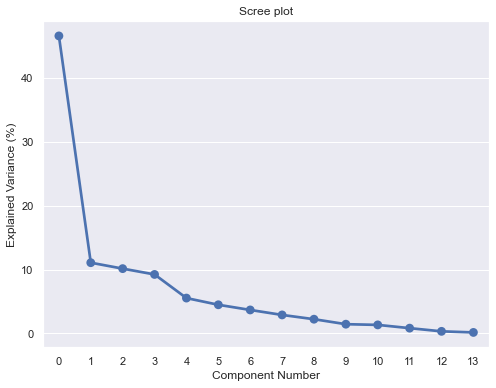

In [105]:
# Produce a scree plot. This plot shows the variance explained by each component
ind = np.arange(0, 14)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance (%)')
plt.show()

### PCA plots (pc1 vs pc2, pc1 vs pc3, pc2 vs pc3)

PCA plots are made for pc1 against pc2, pc1 against pc3 and pc2 against pc3. The countries don't seem to be clustered by CFR. 

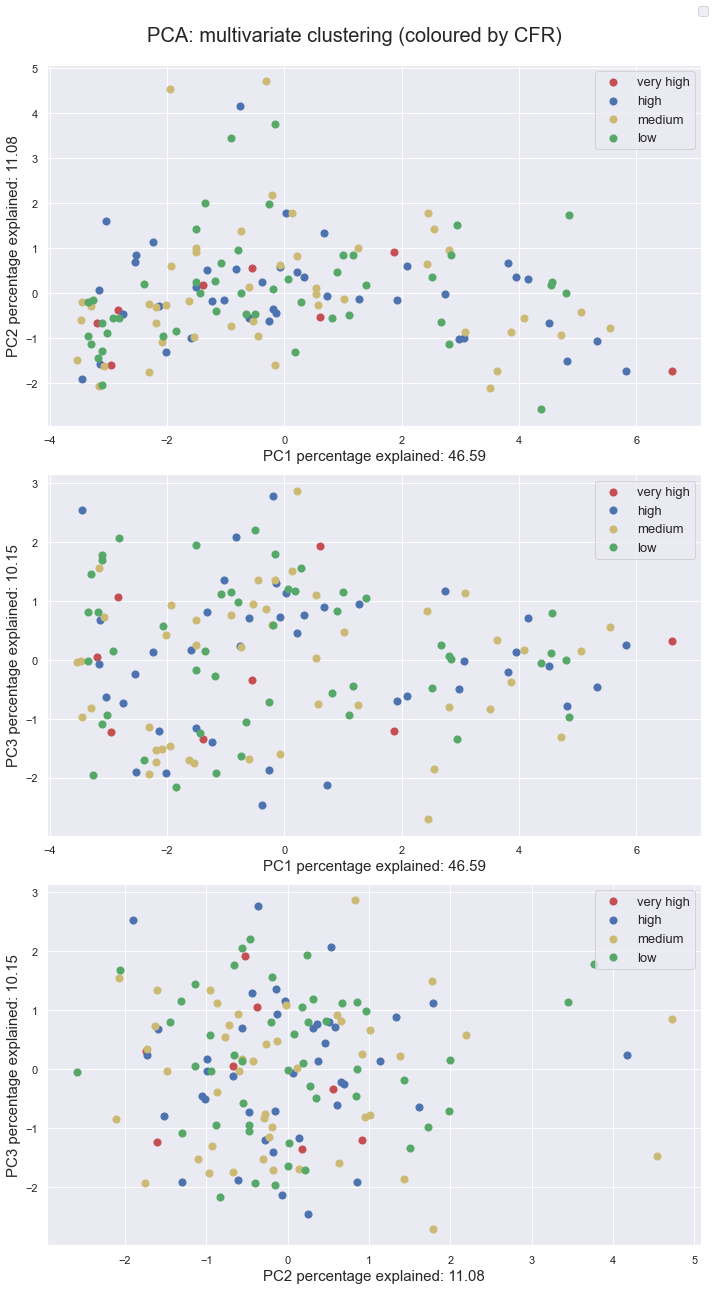

In [108]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,18))

ax[0].set_xlabel('PC1 percentage explained: {}' .format(pca.explained_variance_ratio_[0]) ,fontsize=15)
ax[0].set_ylabel('PC2 percentage explained: {}' .format(pca.explained_variance_ratio_[1]),fontsize=15)

ax[1].set_xlabel('PC1 percentage explained: {}' .format(pca.explained_variance_ratio_[0]) ,fontsize=15)
ax[1].set_ylabel('PC3 percentage explained: {}' .format(pca.explained_variance_ratio_[2]),fontsize=15)

ax[2].set_xlabel('PC2 percentage explained: {}' .format(pca.explained_variance_ratio_[1]) ,fontsize=15)
ax[2].set_ylabel('PC3 percentage explained: {}' .format(pca.explained_variance_ratio_[2]),fontsize=15)

fig.suptitle("PCA: multivariate clustering (coloured by CFR)", fontsize=20)
targets = ['very high','high', 'medium', 'low']
colors = ['r', 'b', 'y', 'g']
fig.legend(targets,prop={'size': 13})

for target, color in zip(targets,colors):
    indicesToKeep = df_new['CFR'] == target
    ax[0].scatter(pc_DF.loc[indicesToKeep, 'pc1']
               , pc_DF.loc[indicesToKeep, 'pc2']
                ,c = color, s = 50)
    ax[0].legend(targets,prop={'size': 13})
    
    ax[1].scatter(pc_DF.loc[indicesToKeep, 'pc1']
               , pc_DF.loc[indicesToKeep, 'pc3']
            ,c = color, s = 50)
    ax[1].legend(targets,prop={'size': 13})
    
    ax[2].scatter(pc_DF.loc[indicesToKeep, 'pc2']
               , pc_DF.loc[indicesToKeep, 'pc3']
            ,c = color, s = 50)
    ax[2].legend(targets,prop={'size': 13})




fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.legend(targets,prop={'size': 13})

## outlier detection

Multivariate outlier detection is done by isolation forest. 14 outliers are detected. They are visualized in the next section.

### Isolation forest

In [125]:
# Reset row indices 
df_values3 = df_values2a.reset_index()

# Select columns
to_model_columns=df_values3.columns

# Make trees for isolation forest and specify the metrics
clf=IsolationForest(n_estimators=1000, max_samples='auto', contamination='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)

# n_estimaters: number of trees (default)
# contamination: proportion of outliers in the datast
# n_jobs: number of jobs to run in parallel. -1 means all processors
# random_state: integer seed to make results reproducible

# fit isolation trees
clf.fit(df_values3[to_model_columns]) 

#predict outliers. -1 is outlier. 1 is inlier.
pred = clf.predict(df_values3[to_model_columns]) 
df_values3['anomaly']=pred
outliers=df_values3.loc[df_values3['anomaly']==-1]

# Save outliers in outlier_index
outlier_index=list(outliers.index)

# Print number of found outliers and inliers
print(df_values3['anomaly'].value_counts())

 1    130
-1     13
Name: anomaly, dtype: int64


## 3D pca with outliers

The outliers are visualized in a 3d pca plot. To inspect if the outliers are overrepresented in some mortality rate classes, the mortality a 3d pca plot with the mortality rate added is plotted below. No significant overrepresentation can be seen. To get an even better view of the outliers, an interactive 3d pca plot has been made.

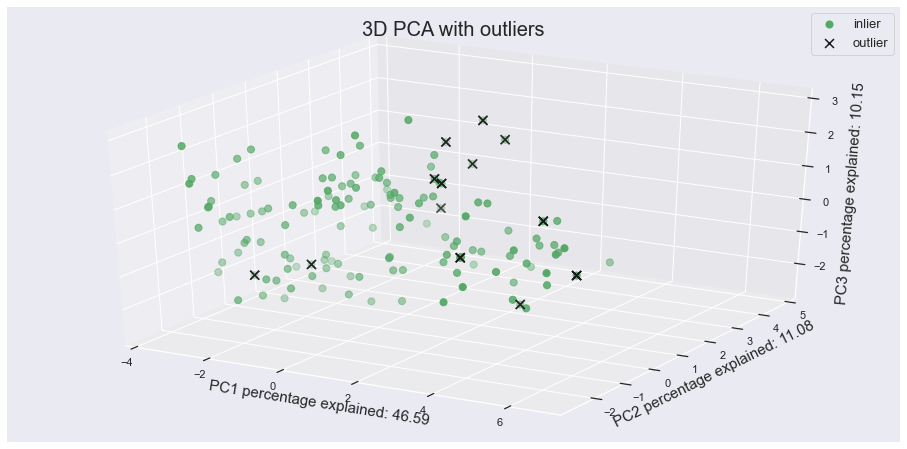

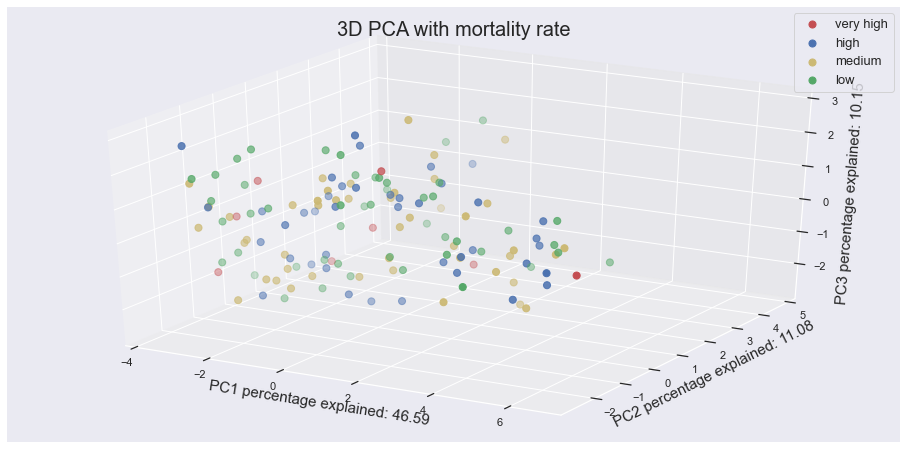

In [126]:
for i in range(2):
    ax[i] = plt.figure(figsize=(16,8)).gca(projection='3d')
    ax[i].set_xlabel('PC1 percentage explained: {}' .format(pca.explained_variance_ratio_[0]) ,fontsize=15)
    ax[i].set_ylabel('PC2 percentage explained: {}' .format(pca.explained_variance_ratio_[1]),fontsize=15)
    ax[i].set_zlabel('PC3 percentage explained: {}' .format(pca.explained_variance_ratio_[2]),fontsize=15)

ax[0].set_title('3D PCA with outliers',fontsize=20)
ax[1].set_title('3D PCA with mortality rate',fontsize=20)

targets = ['very high','high', 'medium', 'low']
colors = ['r', 'b', 'y', 'g']

for target, color in zip(targets,colors):
    indicesToKeep = df_new['CFR'] == target
    ax[0].scatter(pc_DF.loc[indicesToKeep, 'pc1']
               , pc_DF.loc[indicesToKeep, 'pc2']
                ,pc_DF.loc[indicesToKeep, 'pc3'],
                c = 'g', s = 50)
    ax[0].scatter(pc_DF.iloc[outlier_index,0]
           , pc_DF.iloc[outlier_index,1]
            ,pc_DF.iloc[outlier_index,2],
            c = 'k', s = 80, marker = 'x', label='outliers')
    ax[0].legend(['inlier', 'outlier'],prop={'size': 13})
    
    ax[1].scatter(pc_DF.loc[indicesToKeep, 'pc1']
               , pc_DF.loc[indicesToKeep, 'pc2']
                ,pc_DF.loc[indicesToKeep, 'pc3'],
                c = color, s = 50)
    ax[1].legend(targets,prop={'size': 13})

In [157]:
import plotly.express as px
pc_DF['Outliers are labeled 1, inliers are labeled -1'] = df_values3['anomaly']
fig = px.scatter_3d(pc_DF, x='pc1', y='pc2', z='pc3', color='Outliers are labeled 1, inliers are labeled -1', title='3D PCA plot with outliers')
fig.show()

### Remove outliers 

In [158]:
# The outliers found by isolation forest are removed 
df_values4 = df_values3.drop(index=outlier_index, axis=0)
df_values4.to_csv('df_values4.csv')

# Part 2: Regression analysis

After preprocessing, the most important features are searche for. This is done by first comparing linear, PLS and random forest regression and selecting the most important features based on the results of all three methods. Before regression, the df_values4 dataset is being scaled and log transformed.

In [263]:
#Remove the anomaly and index column
df_values5 = df_values4.iloc[:,1:15]

# #Log transform and normalize
df_values5log = np.log2(df_values5)
df5_scaled = StandardScaler().fit_transform(df_values5log)
df_norm1 = pd.DataFrame(df5_scaled)
df_norm1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.326218,0.755839,0.784740,0.029529,0.669516,0.842349,0.342878,0.700925,0.421319,-1.579711,-0.649182,0.578939,0.434104,0.409010
1,-1.118165,-0.139884,-0.302904,0.173682,0.474946,0.031197,-0.147326,0.477353,0.237481,0.773151,0.679462,-0.560118,0.839251,0.564245
2,0.963084,0.189466,-0.056378,0.554669,-0.345054,1.379241,0.662835,0.496060,0.392164,1.417910,-0.550413,-2.806420,0.194122,0.485087
3,-1.174268,0.168487,0.582885,0.443657,-0.350545,-0.374054,0.983602,0.449230,0.648083,0.029138,-0.697222,0.465281,0.895392,-0.066545
4,0.311229,0.546263,0.606232,-0.229036,0.920006,0.141486,0.779815,0.235128,0.243529,-0.948194,0.220866,1.076834,0.309675,-0.127016


In [177]:
df_norm1.mean()

0    -3.586874e-16
1     2.886580e-16
2    -7.344552e-17
3     5.858561e-16
4     8.642659e-16
5     3.928481e-16
6     8.540177e-18
7    -5.072865e-16
8     7.173749e-17
9     6.866302e-16
10    4.162269e-16
11   -9.735802e-17
12    6.509750e-16
13   -4.227388e-16
dtype: float64

In [180]:
#Split data in dependent (y) and independent (x) features
#Because column 0 is the index, this column is not used
x = df_norm1.iloc[:,:len(df_norm1.columns)-1] 
#y is the CFR column
y = df_norm1.iloc[:,len(df_norm1.columns)-1]

## Linear regression 

The performance of linear regression is measured by the root mean square error between the y-test and y-predicted values. The test and predicted values are plotted to visualize the prediction error. 

Text(0, 0.5, 'Number of predicted values per deviation from test data')

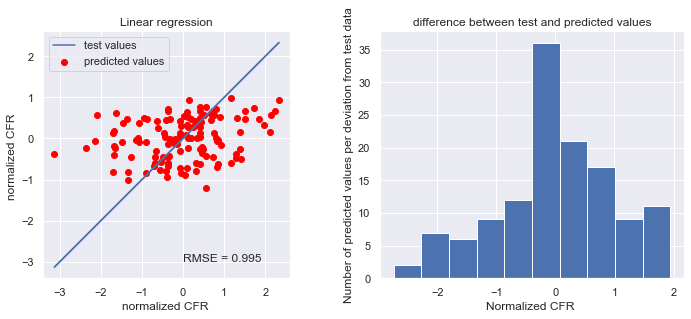

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

# Fit dependent and independent features
LR = LinearRegression()
LR.fit(x,y)

# Predicted values for y are made using 10 fold cross validation
y_predL = cross_val_predict(LR, x, y, cv=10)

# Determine the Root mean square error
RMSE_L = np.sqrt(mean_squared_error(y,y_predL))

#before plotting, the indices need to be removed
y = np.array(y)
predL = pd.DataFrame(y_predL)

#Add the test data and determine the difference between the test and predicted values to make a histogram
predL['y'] = y
predL['diff'] = predL['y'] - predL[0]

#Plot predicted target values against the real target values
ax = plt.figure(figsize=(12,10))

ax1=plt.subplot(221)
ax1.scatter(predL['y'],predL[0],c='red')
ax1.set_title('Linear regression')
ax1.plot(predL['y'], predL['y'])
ax1.set_xlabel('normalized CFR ')
ax1.set_ylabel('normalized CFR ')
ax1.legend(['test values', 'predicted values'], loc=2)
ax1.text(0,-3, 'RMSE = '+str(round(RMSE_L,3)), )
ax1.set_aspect('equal', adjustable='box')
ax2=plt.subplot(222)
ax2.hist(predL['diff'])
ax2.set_title('difference between test and predicted values')
ax2.set_xlabel('Normalized CFR ')
ax2.set_ylabel('Number of predicted values per deviation from test data')

## PLS Regression

The performance of PLS regression is dependent on the number of latent variables used. First, the RSME of PLS regression for 2,3,4 and 5 latent variables is determined. This is done by manually carrying out 10fold cross validation. The plot below shows that the usage of 2 latent variables, results in the lowest RMSE. This number of latent variables is chosen for the PLS regression in the next section.

(104, 13) (104,) (26, 13) (26,)


Text(0, 0.5, 'RSME score')

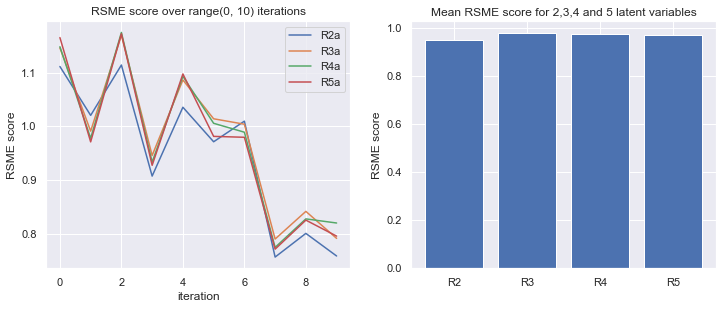

In [207]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

pred2 = []; pred3 = []; pred4 = []; pred5 = [] #Initialize lists for prediction values
R2a = []; R3a = []; R4a = []; R5a = [] #Initialize lists for RSME scores
kfold = range(10) #number of iterations

# K fold cross validation
for i in kfold:
    #split train and test data randomly with 20% test and 80% train data
    train, test = train_test_split(df_norm1, test_size=0.2)
    #y is the target variable CFR
    x_train = train.iloc[:,0:len(df_norm1.columns)-1] 
    x_test = test.iloc[:,0:len(df_norm1.columns)-1] 
    y_train = train.iloc[:,len(df_norm1.columns)-1]
    y_test = test.iloc[:,len(df_norm1.columns)-1]
    
    #Train PLS model
    PLS2 = PLSRegression(n_components=2).fit(x_train,y_train)
    PLS3 = PLSRegression(n_components=3).fit(x_train,y_train)
    PLS4 = PLSRegression(n_components=4).fit(x_train,y_train)
    PLS5 = PLSRegression(n_components=5).fit(x_train,y_train)
    
    #Predict y using the trained model
    y_predP2 = PLS2.predict(x_test); y_predP3 = PLS3.predict(x_test);
    y_predP4 = PLS4.predict(x_test); y_predP5 = PLS5.predict(x_test)
    
    #Append the test results for each kfold iteration in pred{x}
    pred2.append(y_predP2); pred3.append(y_predP3);
    pred4.append(y_predP4); pred5.append(y_predP5)

    #The pred{x} lists are 10x longer than the number of predicted values for each iteration. Here, they are 
    #transformed into dataframes of dimension 42,10

    #convert lists in arrays (3d)
    pred2a = np.array(pred2) ; pred3a = np.array(pred3); pred4a = np.array(pred4); pred5a = np.array(pred5) 
    # delete third dimension
    pred2a = pred2a[:, :, 0]; pred3a = pred3a[:, :, 0]; 
    pred4a = pred4a[:, :, 0]; pred5a = pred5a[:, :, 0]

    #transform so each iteration is a column
    pred2a = pd.DataFrame(pred2a.T)
    pred3a = pd.DataFrame(pred3a.T)
    pred4a = pd.DataFrame(pred4a.T)
    pred5a = pd.DataFrame(pred5a.T)
    
    #Determine the RSME of each iteration and latent variable
    RMSE_P2a = np.sqrt(mean_squared_error(y_test,pred2a.iloc[:,i]))
    RMSE_P3a = np.sqrt(mean_squared_error(y_test,pred3a.iloc[:,i]))
    RMSE_P4a = np.sqrt(mean_squared_error(y_test,pred4a.iloc[:,i]))
    RMSE_P5a = np.sqrt(mean_squared_error(y_test,pred5a.iloc[:,i]))
    
    #Append the RSME values to R{x}a for each kfold iteration
    R2a.append(RMSE_P2a)
    R3a.append(RMSE_P3a)
    R4a.append(RMSE_P4a)
    R5a.append(RMSE_P5a)

    i = i+1
    
#Plot the RSME over the iterations

ax = plt.figure(figsize=(12,10))

ax1=plt.subplot(221)
ax1.plot(R2a); ax1.plot(R3a); ax1.plot(R4a); ax1.plot(R5a)
# plt.hlines(y=sum(R2a)/len(R2a), xmin=0, xmax=10)
ax1.set_title('RSME score over ' + str(kfold) + ' iterations')
ax1.set_xlabel('iteration')
ax1.set_ylabel('RSME score')
ax1.legend(['R2a', 'R3a', 'R4a', 'R5a'])

mean_RSME = np.append(sum(R2a)/len(R2a), sum(R3a)/len(R3a))
mean_RSME = np.append(mean_RSME, sum(R4a)/len(R4a))
mean_RSME = np.append(mean_RSME, sum(R5a)/len(R5a))

ax2=plt.subplot(222)
ax2.bar(['R2','R3','R4','R5'],mean_RSME)
ax2.set_title('Mean RSME score for 2,3,4 and 5 latent variables')
ax2.set_ylabel('RSME score')


PLS regression is carried out with 2 latent variables in a similar way to linear regression. A similar RMSE is obtained compared to linear regression.

Text(0, 0.5, 'Number of predicted values per deviation from test data')

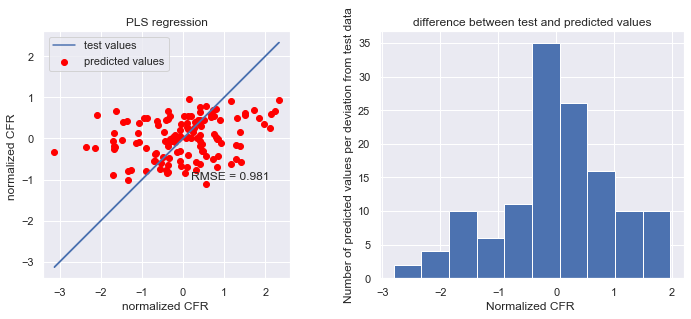

In [222]:
# Fit the data using PLS regression with 2 latent variables
PLS2 = PLSRegression(n_components=2)
PLS2.fit(x,y)

# Predicted values for y are made using 10 fold cross validation
y_predP = cross_val_predict(PLS5, x, y, cv=10)
RMSE_P = np.sqrt(mean_squared_error(y,y_predP))

#before plotting, the indices need to be removed
y = np.array(y)
predP = pd.DataFrame(y_predP)

#Add the test data and determine the difference between the test and predicted values to make a histogram
predP['y'] = y

predP['diff'] = predP['y'] - predP[0]

#Plot predicted target values against the real target values
ax = plt.figure(figsize=(12,10))

ax1=plt.subplot(221)
ax1.scatter(predP['y'],predP[0],c='red')
ax1.set_title('PLS regression')
ax1.plot(predP['y'], predP['y'])
ax1.set_xlabel('normalized CFR ')
ax1.set_ylabel('normalized CFR ')
ax1.legend(['test values', 'predicted values'], loc=2)
ax1.text(0.2,-1.0, 'RMSE = '+str(round(RMSE_P,3)))
ax1.set_aspect('equal', adjustable='box')
ax2=plt.subplot(222)
ax2.hist(predP['diff'])
ax2.set_title('difference between test and predicted values')
ax2.set_xlabel('Normalized CFR ')
ax2.set_ylabel('Number of predicted values per deviation from test data')

## Random forest regression

The performance of random forest regression is dependent on multiple factors of which the number of trees (estimators) and max_feature setting are important parameters. The out of bag (OOB) error is a measure of the random forest performance. A lower error means a better performance. Below, the OOB error is plotted for a random forest regressor with max_features set to sqrt compared to one with max_features set to auto. The OOB error is plotted from 100 to 5000 trees. The plot below shows that after about 2000 trees, the OOB error doesn't improve anymore, meaning that not more than 2500 trees are necessary to run the random forest algorithm.

13942.073926210403


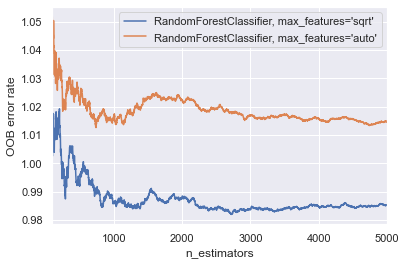

In [252]:
from collections import OrderedDict 
import time

# A list of Random forest regressors with max_features='sqrt' and max_features='auto' is made. 
# The oob_score is turned on.
ensemble_RFR = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features='sqrt',
                               random_state=1, n_jobs=-1)),
    ("RandomForestRegressor, max_features='auto'",
        RandomForestRegressor(warm_start=True, max_features='auto',
                               oob_score=True,
                               random_state=1, n_jobs=-1))
]

# A regressor label is mapped to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_RFR)

# The range of the n_estimators values is set.
min_estimators = 100
max_estimators = 5000
# This calculation takes a while. For performance metrics, the time is measured.
start = time.time()

# For the range of estimators set, the random forest regressor is fitted and the OOB error rate is calculated 
for label, RFR in ensemble_RFR:
    for i in range(min_estimators, max_estimators + 1):
        RFR.set_params(n_estimators=i, n_jobs=-1)
        RFR.fit(x, y)
        oob_error = 1 - RFR.oob_score_
        error_rate[label].append((i, oob_error))
    
# A plot between the OOB error rate and the number of trees is made
for label, RFR_err in error_rate.items():
        xs, ys = zip(*RFR_err)
        plt.plot(xs, ys, label=label) 
        plt.xlim(min_estimators, max_estimators)
        plt.xlabel("n_estimators")
        plt.ylabel("OOB error rate")
        plt.legend(loc="upper right")    
end = time.time()

print(end-start)

Text(0, 0.5, 'Number of predicted values per deviation from test data')

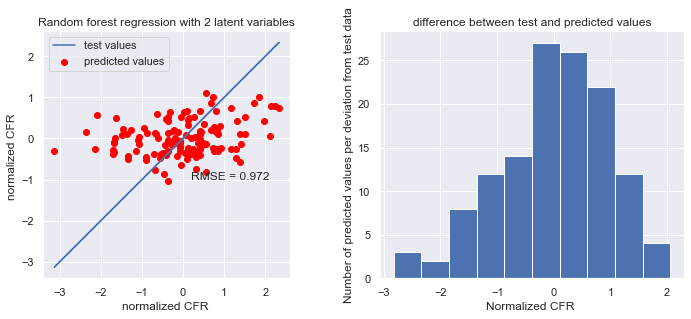

In [255]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

# A random forest regressor is run for 2500 trees and a max_features setting of sqrt.
RFR = RandomForestRegressor(n_estimators = 2500, oob_score=True, max_features='sqrt',min_samples_split=4, n_jobs=-1)
RFR.fit(x,y)

# 10fold cross validation is done to get the target predictions
y_predR = cross_val_predict(RFR, x, y, cv=10)

# The RMSE is determined 
RMSE_R = np.sqrt(mean_squared_error(y,y_predR))

#before plotting, the indices need to be removed
y = np.array(y)
predRb = pd.DataFrame(y_predR)

#Add the test data and determine the difference between the test and predicted values to make a histogram
predRb['y'] = y
predRb['diff'] = predRb['y'] - predRb[0]

#Plot predicted target values against the real target values
ax = plt.figure(figsize=(12,10))

ax1=plt.subplot(221)
ax1.scatter(predRb['y'],predRb[0],c='red')
ax1.set_title('Random forest regression with 2 latent variables')
ax1.plot(predRb['y'], predRb['y'])
ax1.set_xlabel('normalized CFR ')
ax1.set_ylabel('normalized CFR ')
ax1.legend(['test values', 'predicted values'], loc=2)
ax1.text(0.2,-1.0, 'RMSE = '+str(round(RMSE_R,3)))
ax1.set_aspect('equal', adjustable='box')
ax2=plt.subplot(222)
ax2.hist(predRb['diff'])
ax2.set_title('difference between test and predicted values')
ax2.set_xlabel('Normalized CFR ')
ax2.set_ylabel('Number of predicted values per deviation from test data')

# Compare regression techniques

Plots from linear, PLS and Random Forest regression are plotted next to each other to better compare their outcomes. The RMSE for all techniques can be seen to be similar, with a very slight advantage for Random forest regression. 

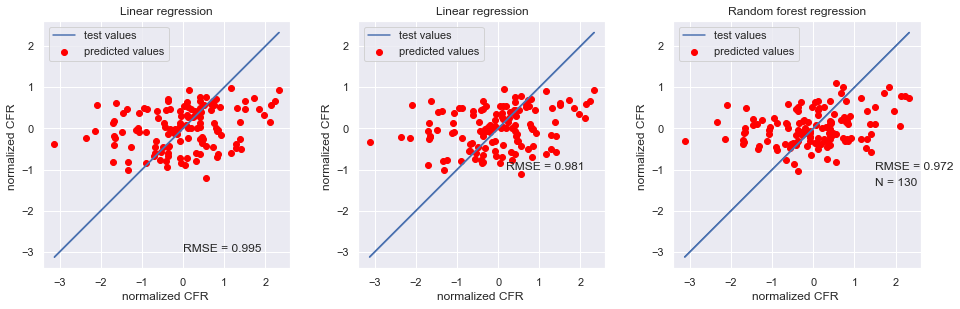

In [256]:
ax = plt.figure(figsize=(16,10))

ax1=plt.subplot(231)
ax1.scatter(predL['y'],predL[0],c='red')
ax1.set_title('Linear regression')
ax1.plot(predL['y'], predL['y'])
ax1.set_xlabel('normalized CFR ')
ax1.set_ylabel('normalized CFR ')
ax1.legend(['test values', 'predicted values'], loc=2)
ax1.text(0,-3, 'RMSE = '+str(round(RMSE_L,3)), )
ax1.set_aspect('equal', adjustable='box')

ax2=plt.subplot(232)
ax2.scatter(predP['y'],predP[0],c='red')
ax2.set_title('Linear regression')
ax2.plot(predP['y'], predP['y'])
ax2.set_xlabel('normalized CFR ')
ax2.set_ylabel('normalized CFR ')
ax2.legend(['test values', 'predicted values'], loc=2)
ax2.text(0.2,-1.0, 'RMSE = '+str(round(RMSE_P,3)))
ax2.set_aspect('equal', adjustable='box')

ax3=plt.subplot(233)
ax3.scatter(predRb['y'],predRb[0],c='red')
ax3.set_title('Random forest regression')
ax3.plot(predRb['y'], predRb['y'])
ax3.set_xlabel('normalized CFR ')
ax3.set_ylabel('normalized CFR ')
ax3.legend(['test values', 'predicted values'], loc=2)
ax3.text(1.5,-1.0, 'RMSE = '+str(round(RMSE_R,3)))
ax3.text(1.5,-1.4, 'N = '+str(len(predRb[0])))
ax3.set_aspect('equal', adjustable='box')

## Feature importance visualization 

Before visualization, the feature importances for each method is obtained and stored in the "feat" dataframe.

In [264]:
#Preprocessing before visualization
df_values6 = df_values5log.drop(columns= 'CFR')

feat = pd.DataFrame(df_values6.columns)

# Get new column names: feat_cols
feat_cols = [i for i in range(df_values6.shape[1])]

# Add feature importances and coefficients to the feat dataframe
feat = pd.DataFrame(df_values6.columns)
feat['importance'] = RFR.feature_importances_
feat['Linear Regression importance'] = abs(LR.coef_)
feat['PLS Regression importance'] = abs(PLS2.coef_)
feat['Linear Regression coefficient'] = LR.coef_
feat['PLS Regression coefficient'] = PLS2.coef_
feat['average'] = (feat['importance']+feat['Linear Regression importance']+feat['PLS Regression importance'])/3
feat

,0,importance,Linear Regression importance,PLS Regression importance,Linear Regression coefficient,PLS Regression coefficient,average
0,population_density,0.078903,0.057550,0.035512,0.057550,0.035512,0.057322
1,median_age,0.093008,0.472993,0.064961,0.472993,0.064961,0.210320
2,aged_70_older,0.102243,0.070398,0.112034,0.070398,0.112034,0.094891
3,gdp_per_capita,0.072806,0.096335,0.017841,-0.096335,0.017841,0.062327
4,cardiovasc_death_rate,0.090214,0.257954,0.186820,-0.257954,-0.186820,0.178329
5,diabetes_prevalence,0.061339,0.081962,0.132444,-0.081962,-0.132444,0.091915
6,hospital_beds_per_thousand,0.052998,0.165619,0.058848,-0.165619,-0.058848,0.092488
7,life_expectancy,0.083401,0.246768,0.033669,-0.246768,0.033669,0.121279
8,human_development_index,0.086440,0.050376,0.012651,-0.050376,0.012651,0.049823
9,Asthma Prevalence (m/f) Age-standardized,0.054067,0.096828,0.026823,-0.096828,-0.026823,0.059239


The feature importances are plotted against each other. The plot below shows that the methods don't agree on the most important features and on the level of importance. Also on average, linear regression gives much higher feature importance values than random forest regression.  

Text(0.6, 0, '0: population_density')

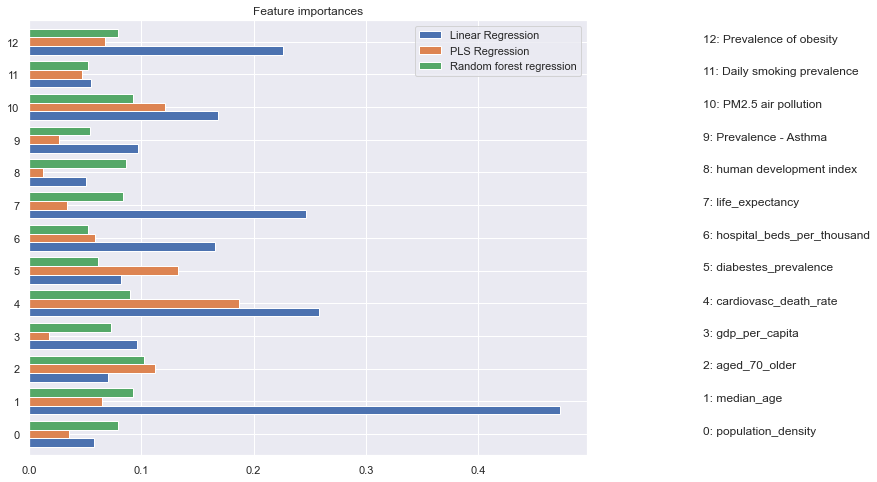

In [265]:
# The feature importances are plotted in a horizontal bar graph
df10 = pd.DataFrame({'Linear Regression': feat['Linear Regression importance'],
            'PLS Regression': feat['PLS Regression importance'],
                    'Random forest regression': feat['importance']}, index=feat_cols)

ax = df10.plot.barh(width = 0.8, figsize=(10,8))
ax.set_title('Feature importances')

plt.text(0.6, 12, '12: Prevalence of obesity')
plt.text(0.6, 11, '11: Daily smoking prevalence')
plt.text(0.6, 10, '10: PM2.5 air pollution')
plt.text(0.6, 9, '9: Prevalence - Asthma')
plt.text(0.6, 8, '8: human development index')
plt.text(0.6, 7, '7: life_expectancy')
plt.text(0.6, 6, '6: hospital_beds_per_thousand')
plt.text(0.6, 5, '5: diabestes_prevalence')
plt.text(0.6, 4, '4: cardiovasc_death_rate')
plt.text(0.6, 3, '3: gdp_per_capita')
plt.text(0.6, 2, '2: aged_70_older')
plt.text(0.6, 1, '1: median_age')
plt.text(0.6, 0, '0: population_density')

Because of the very similar RMSE values between the regression methods, the importances of each method can be combined to get a more robust importance measure. This is plotted below. This plot shows the median age and the cardivascular death rate to be the two most important factors on the case fatality rate.

Text(0.25, 0, '0: population_density')

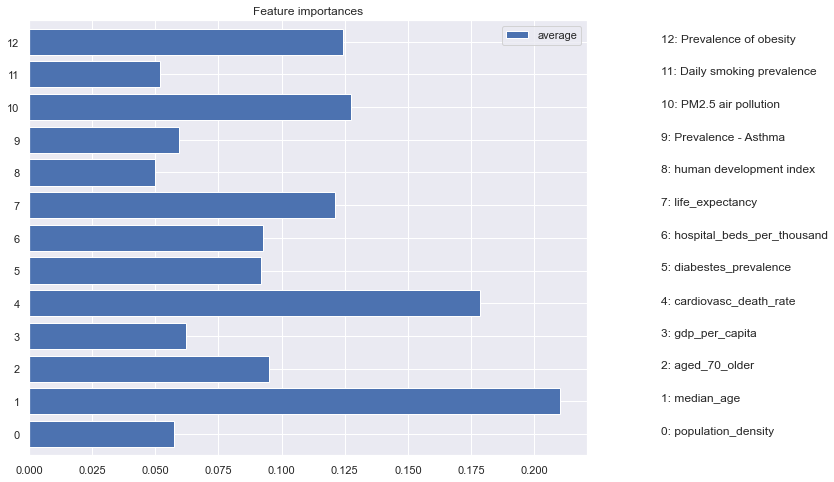

In [266]:
# Now, the average feature importances are plotted
df9 = pd.DataFrame({'average': feat['average']}, index=feat_cols)
ax = df9.plot.barh(width = 0.8, figsize=(10,8))
ax.set_title('Feature importances')

plt.text(0.25, 12, '12: Prevalence of obesity')
plt.text(0.25, 11, '11: Daily smoking prevalence')
plt.text(0.25, 10, '10: PM2.5 air pollution')
plt.text(0.25, 9, '9: Prevalence - Asthma')
plt.text(0.25, 8, '8: human development index')
plt.text(0.25, 7, '7: life_expectancy')
plt.text(0.25, 6, '6: hospital_beds_per_thousand')
plt.text(0.25, 5, '5: diabestes_prevalence')
plt.text(0.25, 4, '4: cardiovasc_death_rate')
plt.text(0.25, 3, '3: gdp_per_capita')
plt.text(0.25, 2, '2: aged_70_older')
plt.text(0.25, 1, '1: median_age')
plt.text(0.25, 0, '0: population_density')

The feature importances for the linear and PLS regression methods were determined by taking the absolute value of their coefficients. The coefficients give information about the direction of the effect on CFR. These values represent the mean change in the response given a one unit change in the predictor. For example, if a coefficient is +3, the mean response value increases by 3 for every one unit change in the predictor. The plot below shows that a higher median age results in a higher CFR, while a lower cardiocascular death rate also results in a higher CFR. These results should be interpreted carefully as linear and PLS regression sometimes show very different results.

Text(0.55, 0, '0: population_density')

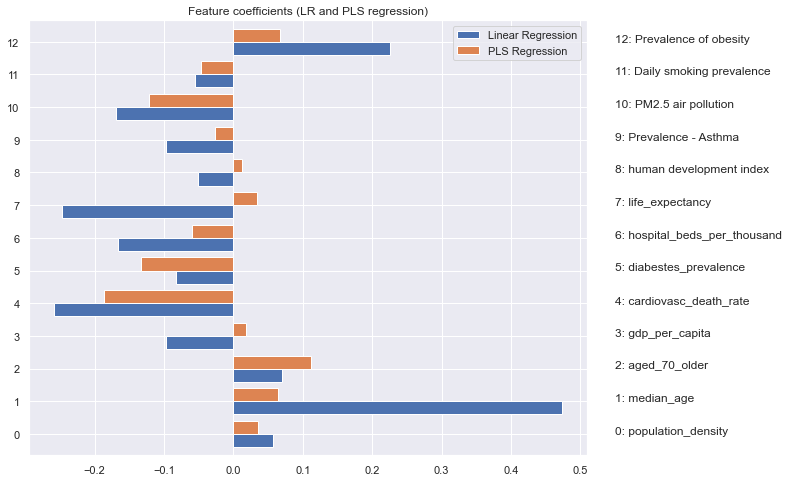

In [272]:
# A dataframe with linear and PLS regression feature coefficients is made
df11 = pd.DataFrame({'Linear Regression': feat['Linear Regression coefficient'],
            'PLS Regression': feat['PLS Regression coefficient']}, index=feat_cols)

# A horizontal bar plot comparing linear and PLS regression is made
ax = df11.plot.barh(width = 0.8, figsize=(10,8))
ax.set_title('Feature coefficients (LR and PLS regression)')

plt.text(0.55, 12, '12: Prevalence of obesity')
plt.text(0.55, 11, '11: Daily smoking prevalence')
plt.text(0.55, 10, '10: PM2.5 air pollution')
plt.text(0.55, 9, '9: Prevalence - Asthma')
plt.text(0.55, 8, '8: human development index')
plt.text(0.55, 7, '7: life_expectancy')
plt.text(0.55, 6, '6: hospital_beds_per_thousand')
plt.text(0.55, 5, '5: diabestes_prevalence')
plt.text(0.55, 4, '4: cardiovasc_death_rate')
plt.text(0.55, 3, '3: gdp_per_capita')
plt.text(0.55, 2, '2: aged_70_older')
plt.text(0.55, 1, '1: median_age')
plt.text(0.55, 0, '0: population_density')

## # Part 3: Correlation analysis 

Correlations between variables can be obtained in various ways. Here, feature correlations are obtained from a circle using principle components and by calculating pearson product correlations. 

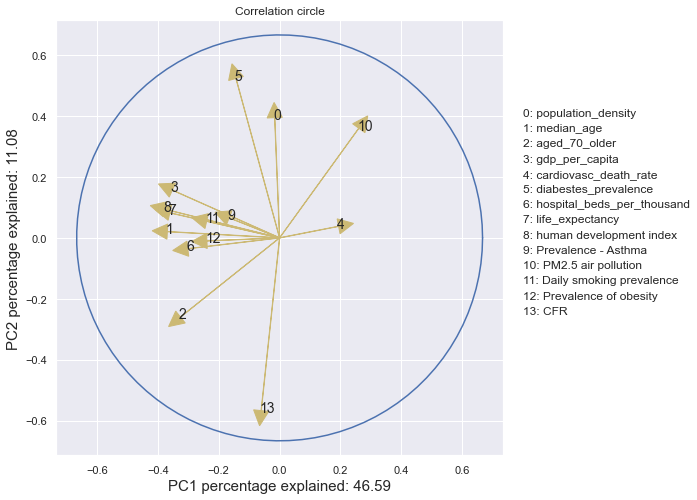

In [273]:
# Store feature names in feat_cols1
feat_cols1 = [str(i) for i in range(df_scaled.shape[1])]

# Plot the correlation circle
(fig, ax) = plt.subplots(figsize=(8, 8))
# Each principle component is plotted as an arrow starting from the center.
for i in range(0, len(pca.components_)):
    ax.arrow(0,
             0,  # Start the arrow at the center
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05,
            color='y')
# The PC names are plotted right at the head of each arrow
    plt.text(pca.components_[0, i] + -0.005,
         pca.components_[1, i] + -0.005,
         #df_norm.columns.values[i],
             feat_cols1[i],
             fontsize=14)

# A circle is plotted to make the length of each arrow more comparable.
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an)/1.5, np.sin(an)/1.5)  # Add a unit circle for scale
plt.axis('equal')

ax.set_title('Correlation circle')
ax.set_xlabel('PC1 percentage explained: {}' .format(pca.explained_variance_ratio_[0]) ,fontsize=15)
ax.set_ylabel('PC2 percentage explained: {}' .format(pca.explained_variance_ratio_[1]),fontsize=15)
plt.text(0.8, 0.4, '0: population_density')
plt.text(0.8, 0.35, '1: median_age')
plt.text(0.8, 0.3, '2: aged_70_older')
plt.text(0.8, 0.25, '3: gdp_per_capita')
plt.text(0.8, 0.2, '4: cardiovasc_death_rate')
plt.text(0.8, 0.15, '5: diabestes_prevalence')
plt.text(0.8, 0.1, '6: hospital_beds_per_thousand')
plt.text(0.8, 0.05, '7: life_expectancy')
plt.text(0.8, 0, '8: human development index')
plt.text(0.8, -0.05, '9: Prevalence - Asthma')
plt.text(0.8, -0.1, '10: PM2.5 air pollution')
plt.text(0.8, -0.15, '11: Daily smoking prevalence')
plt.text(0.8, -0.2, '12: Prevalence of obesity')
plt.text(0.8, -0.25, '13: CFR')
plt.show()

The pearson product correlations for each feature is calculated and plotted in the figure below. A negative correlation means that when feature A goes up, feature B goes down. The plot below shows a lot of positive and negative correlations. In particular, the correlation between the median age and both the life expectancy and human development index is very high (0.9). This positive correlation is also seen in the correlation circle but is a bit weaker than in the pearson product correlation matrix. 

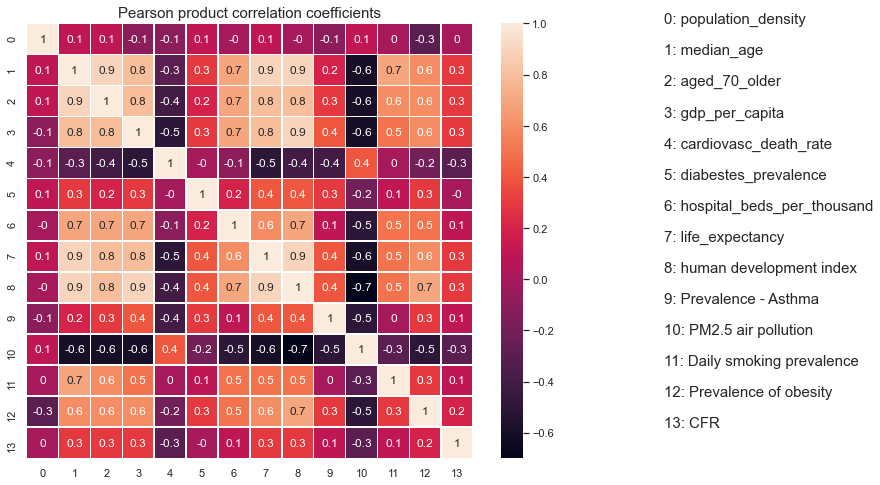

In [251]:
from sklearn.cross_decomposition import PLSCanonical, CCA

# Derive the pearson correlations from df_values5log
ca = np.round(np.corrcoef(df_values5log.T), 1)

# Plot heatmap from the pearson product correlations
fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(ca, annot=True, linewidths=.5)

ax.set_title('Pearson product correlation coefficients', fontsize=15)
plt.text(20, 0, '0: population_density', fontsize=15)
plt.text(20, 1, '1: median_age', fontsize=15)
plt.text(20, 2, '2: aged_70_older', fontsize=15)
plt.text(20, 3, '3: gdp_per_capita', fontsize=15)
plt.text(20, 4, '4: cardiovasc_death_rate', fontsize=15)
plt.text(20, 5, '5: diabestes_prevalence', fontsize=15)
plt.text(20, 6, '6: hospital_beds_per_thousand', fontsize=15)
plt.text(20, 7, '7: life_expectancy', fontsize=15)
plt.text(20, 8, '8: human development index', fontsize=15)
plt.text(20, 9, '9: Prevalence - Asthma', fontsize=15)
plt.text(20, 10, '10: PM2.5 air pollution', fontsize=15)
plt.text(20, 11, '11: Daily smoking prevalence', fontsize=15)
plt.text(20, 12, '12: Prevalence of obesity', fontsize=15)
plt.text(20, 13, '13: CFR', fontsize=15)

plt.show()

## Part 4: Clustering analysis

Density-based spatial clustering of applications with noise (DBSCAN) is a clustering technique based on sample density. Compared to other clustering techniques like hierarchical and k-means clustering, it has the advantage that the number of clusters don't have to prespecified. Another reason why it is used is its ability to find arbitrary and irregularly shaped clusters. In this section, DBSCAN is used to cluster 2 of the most important features. Their location data is then obtained, which is then plotted to search for clusters within parts of the world. 

In [345]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Initiate DBSCAN and fit the values of df_values5log
dbscan=DBSCAN()
dbscan.fit(df_values5log)
df_values5log['DBSCAN_labels']=dbscan.labels_ 

# The distances between all countries are obtained. 
# The features, aged_70_older and human_development_index are used.
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_values5log[['aged_70_older', 'human_development_index']])
distances, indices = nbrs.kneighbors(df_values5log[['aged_70_older', 'human_development_index']])

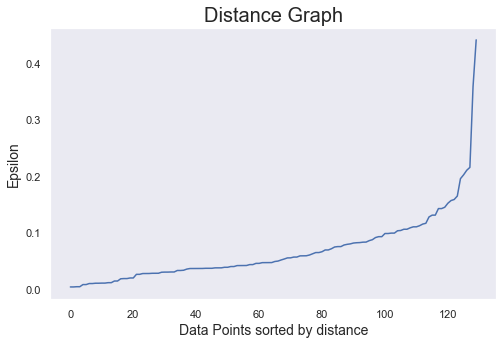

In [346]:
# DBSCAN uses the epsilon and min_samples parameters. The epsilon parameter can be estimated 
# by plotting the distances.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title('Distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Plotting the distances shows a maximal curvature at an epsilon of about 0.15. This means that the best clustering performance will be obtained using this parameter value. The min_samples parameter impacts the number of clusters that are created. Setting parameter can be done using trial and error. Setting the parameter too high results in a lot of outlier samples, while setting the parameter too low results in too many clusters to analyze. Here, a min_samples values of 3 is chosen. 

In [306]:
from sklearn.cluster import DBSCAN
# Set the DBSCAN parameters
dbscan_opt=DBSCAN(eps=0.17,min_samples=3)

# Fit the features to obtain the cluster labels
dbscan_opt.fit(df_values5log[['median_age', 'cardiovasc_death_rate']])

# Add the cluster labels to df_values5log for plotting
df_values5log['DBSCAN_opt_labels']=dbscan_opt.labels_

# A cluster label of -1 means that the sample is an outlier and cannot be clustered. All cluster labels from zero
# onwards are clusters. 
df_values5log['DBSCAN_opt_labels'].value_counts()

 1    50
 0    23
 3    21
-1    16
 2    13
 4     7
Name: DBSCAN_opt_labels, dtype: int64

To check the clusters made in DBSCAN clustering, we plot both labeled features against each other. We can indeed see sensible clusters. The dark blue dots are outliers.

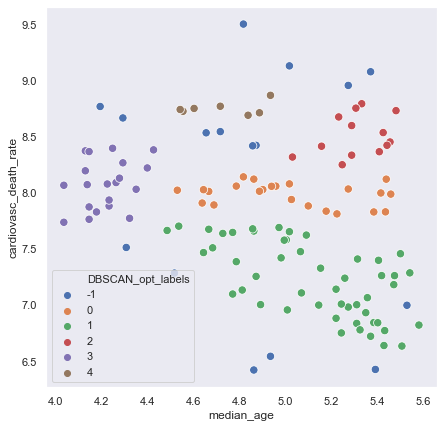

In [307]:
# Set plotting style and plot the features against each other
sns.set_style("dark")
plt.figure(figsize=(7,7))

sns.scatterplot(data=df_values5log, x="median_age", y="cardiovasc_death_rate", 
                hue="DBSCAN_opt_labels", 
                palette="deep", s=70)

In order to find geographical clusters, the location data for each country has to be obtained. First, the countries still represented in the df_values5log dataset are selected.

In [310]:
#Select the countries with indices concurring with the indices of the df_values5log rows.
df_countries = df_new['location']
df_index = pd.DataFrame(df_index)
df_countries = pd.DataFrame(df_countries)
df_countries['index'] = df_countries.index
df_index.columns = ['index']
df_countries = df_index.merge(df_countries, on='index', how='left')

#Add countries to dataframe
df_countries['DBSCAN_labels'] = df_values5log['DBSCAN_opt_labels']

In [ ]:
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim 

# Initiate empty lists for longitude and latitude
longitude = [] 
latitude = [] 
   
# This function finds the coordinate for of a given country using geolocator
def findGeocode(country):       
    # Try and catch is used to overcome the exception thrown by geolocator using geocodertimedout   
    try:           
        # Here, the user agent is specified
        geolocator = Nominatim(user_agent="your_app_name")           
        return geolocator.geocode(country)      
    except GeocoderTimedOut:           
        return findGeocode(country)     
  
 # Nowe, each value from city column is fetched and sent to function find_geocode    
for i in (df_countries["location"]):       
    if findGeocode(i) != None:           
        loc = findGeocode(i) 
          
        # The coordinates found are stored the empty longitude and latitude lists
        latitude.append(loc.latitude) 
        longitude.append(loc.longitude) 
       
    # If the coordinate for a country is not found, "NaN" is inserted, indicating a missing value  
    else: 
        latitude.append(np.nan) 
        longitude.append(np.nan) 

In [311]:
# Add the longitude and latitudes coordinates to the countries dataframe
df_countries["Longitude"] = longitude 
df_countries["Latitude"] = latitude 

The coordinates of each country is plotted. The resulting scatterplot shows the location of each country. Although a world map is not displayed, the geographial locations of each dot can be constructed. The plot below shows that  South-American, Middle-eastern and East European countries are clustered toghether. European and African countries are more heterogeneous.

Text(0, 0.5, 'Latitude')

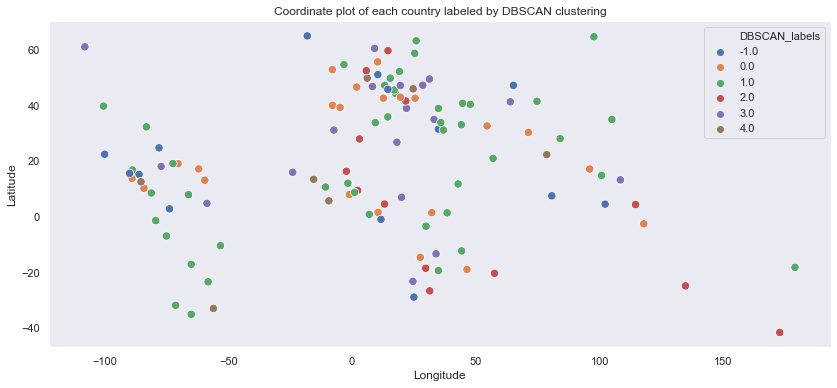

In [312]:
# Plot the coordinates with the cluster labels. 
(fig, ax) = plt.subplots(figsize=(14, 6))
sns.scatterplot(data=df_countries, x="Longitude", y="Latitude", hue="DBSCAN_labels", palette="deep"
               , s=70)
ax.set_title('Coordinate plot of each country labeled by DBSCAN clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Geographical clusters can also be analyzed by applying DBSCAN clustering to all features. This should result in roughly the same geographical clusters as seen in the previous coordinate plot and should add confidence to the geographical clusters shown. Below, the same DBSCAN analysis is done on all features at the same time to find general geographical clusters 

In [343]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Initiate DBSCAN and fit the values of df_values5log
dbscan=DBSCAN()
dbscan.fit(df_values5log)
df_values5log['DBSCAN_labels_full']=dbscan.labels_ 

# The distances between all countries are obtained. 
# The features, aged_70_older and human_development_index are used.
neigh = NearestNeighbors(n_neighbors=14)
nbrs = neigh.fit(df_values5log)
distances, indices = nbrs.kneighbors(df_values5log)

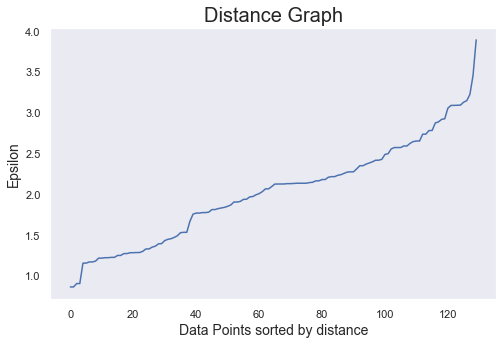

In [344]:
# DBSCAN uses the epsilon and min_samples parameters. The epsilon parameter can be estimated 
# by plotting the distances.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title('Distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

The above plot shows a maximum curvature at an epsilon of about 2.7. This epsilon is used for the DBSCAN clustering below.

In [338]:
# Set parameters and fit df_values5log
dbscan_opt=DBSCAN(eps=2.7,min_samples=2)
dbscan_opt.fit(df_values5log)

# Add the list of labels to df_countries
df_countries['DBSCAN_labels_full']=dbscan_opt.labels_
df_countries['DBSCAN_labels_full'].value_counts()

 0    100
-1     18
 1      5
 2      3
 4      2
 3      2
Name: DBSCAN_labels_full, dtype: int64

Below, the coordinates of each country and DBSCAN labels based on the whole df_values5log dataframe are plotted. Here, the clusters are much more spreaded geographically. Cluster zero can be seen in most European, American and African and Middle-Eastern countries. Central and East Asian countries are notebly more often outliers. 

Text(0, 0.5, 'Latitude')

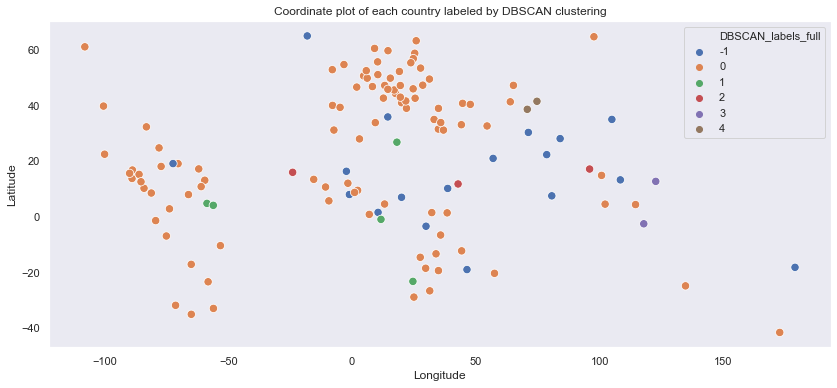

In [336]:
# Plot the coordinate plot
(fig, ax) = plt.subplots(figsize=(14, 6))
sns.scatterplot(data=df_countries, x="Longitude", y="Latitude", hue="DBSCAN_labels_full", palette="deep"
               , s=70)
ax.set_title('Coordinate plot of each country labeled by DBSCAN clustering')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Discussion and Conclusion

This project aimed to find the most important factors contributing to the COVID19 fatality rate. The median age and cardiovascular death rate have been identified as important factors, while the population density and the human development index have been identified to be unimportant factors. These results should be taken with a grain of salt. The agreement between all three regression methods was low. An average of the regression outputs should be seen as a rough estimate. Another factor to keep in mind is that only 13 factors are used in this data analysis.  There are likely much more factors contributing to the case fatatlity rate. Future analysis should include more risk factors to get to a more complete picture of the most important COVID19 risk factors. Furthermore, the performance of the regression methods could be improved by hyperparameter optimization. This is done in part for random forest regression, but could be carried out more extensively. 

A second goal for this project was to find correlations between the risk factors. Many high positive correlations were found between factors. An example is the correlation between life expectancy and human development index. DBSCAN clustering was done to find geographical clusters between countries. When only taking the median age and cardiovascular death rate into account, clear clusters could be seen. These clusters disappeared when all risk factors were taken into account. This might be explained by that not all risk factors are correlated or even negatively correlated. By taking into account contrasting features, it might become hard to find good clusters. 

Despite its limitations, this research project managed to identify important risk factors that influence COVID19 mortality rate and found correlated risk factors. It also identified clusters of countries with similar levels of importatn factors impacting COVID19 mortality rate.